In [12]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.optimizers import Adam 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

In [13]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq,max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

In [14]:
nine_idx = np.array([i for i in range(len(df_h)) if (np.count_nonzero(X[i])==9)])
X_9 = X[nine_idx]
y_9 = y[nine_idx]

In [15]:
len(X_9),len(X)

(6961, 9565)

In [20]:
X_9[1][9]

0

In [26]:
def delete_char_from_nine_onwards(X):
    return np.delete(X, np.arange(9,max_len,1), None)

In [31]:
X_9_shortened = np.zeros((len(X_9),9))

In [32]:
for i in range(len(X_9)):
    X_9_shortened[i] = np.delete(X_9[i], np.arange(9,max_len,1), None)

In [34]:
X_9_shortened[1]

array([  1.,   1.,   1.,   9.,   1.,   1.,   1.,   1.,  18.])

In [38]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0





train_nn_aucs = np.zeros((folds,n_epochs))
test_nn_aucs = np.zeros((folds,n_epochs))



train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))



for i, (train_idx, test_idx) in enumerate(KFold(len(X_9),folds, shuffle=True)):
    

    
    
    # neural net
    nn = Sequential()
    nn.add(Embedding(input_dim = 21, input_length =9, output_dim= 32))
    nn.add(Flatten())
    nn.add(Dense(10, init='glorot_uniform', activation='sigmoid'))
    nn.add(Dense(1, init='glorot_uniform', activation='sigmoid'))
    
    nn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    
    # lstm 
    sequence = Input( shape= (9, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 9, output_dim= 32)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    adam = Adam(lr=0.01)
    lstm.compile(optimizer = adam, loss='mean_squared_error')
    
    
    # index sets
    
    nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])==9)])
    non_nine_train_idx = np.array([i for i in train_idx if (np.count_nonzero(X[i])!=9)])
    nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])==9)])
    non_nine_test_idx = np.array([i for i in test_idx if (np.count_nonzero(X[i])!=9)])
    
  
    
    for epoch in range(n_epochs):
        
        
        
        
        # nn
        nn.fit(X_9_shortened[train_idx],y_9[train_idx], batch_size = batch_size_nn, nb_epoch=1)
   

        train_nn_auc = roc_auc_score(measured_affinity_less_than(y_9[train_idx],500), nn.predict(X_9_shortened[train_idx]))     
        test_nn_auc = roc_auc_score(measured_affinity_less_than(y_9[test_idx],500), nn.predict(X_9_shortened[test_idx]))
        
        
        
        train_nn_aucs[i][epoch]=train_nn_auc
        test_nn_aucs[i][epoch]=test_nn_auc
        
        
        
        #lstm 
        adam.lr.set_value(0.01*(epoch+1)**(-2))
        lstm.fit(X_9_shortened[train_idx],y_9[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
    
        train_lstm_auc = roc_auc_score(measured_affinity_less_than(y_9[train_idx],500), lstm.predict(X_9_shortened[train_idx]))     
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(y_9[test_idx],500), lstm.predict(X_9_shortened[test_idx]))
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc

        
        print("All: ", test_nn_auc, test_lstm_auc, epoch, i)
  

Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0717     
Epoch 1/1
4640/4640 [==============================] - 4s - loss: 0.0469     
All:  0.936376970085 0.938163501119 0 0
Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0337     
Epoch 1/1
4640/4640 [==============================] - 4s - loss: 0.0279     
All:  0.952477242793 0.955766592042 1 0
Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0267     
Epoch 1/1
4640/4640 [==============================] - 4s - loss: 0.0246     
All:  0.958178151018 0.956932393814 2 0
Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0243     
Epoch 1/1
4640/4640 [==============================] - 4s - loss: 0.0227     
All:  0.960036040126 0.957599548811 3 0
Epoch 1/1
4640/4640 [==============================] - 0s - loss: 0.0231     
Epoch 1/1
4640/4640 [==============================] - 4s - loss: 0.0225     
All:  0.960943061416 0.957878962952 4 0
Epoch 1/1
4640/4640 

In [40]:
train_nn_aucs_mean = np.mean(train_nn_aucs, axis=0)
test_nn_aucs_mean = np.mean(test_nn_aucs, axis=0)
train_lstm_aucs_mean=np.mean(train_lstm_aucs, axis=0)
test_lstm_aucs_mean=np.mean(test_lstm_aucs, axis=0)

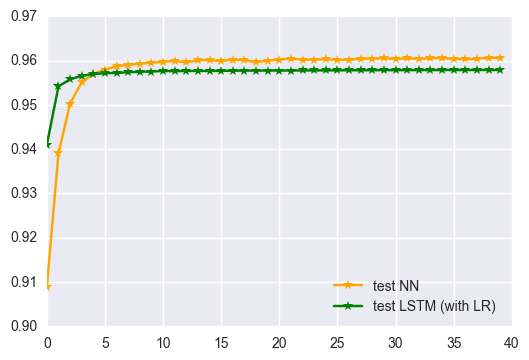

In [41]:
plt.plot( np.arange(0,40,1), test_nn_aucs_mean[0:40],color='orange',marker='*', linestyle='-', label ="test NN ")
plt.plot( np.arange(0,40,1), test_lstm_aucs_mean[0:40],color='g',marker='*', linestyle='-', label ="test LSTM (with LR) ")

plt.legend(loc=4)